# Style Transfer - Part 1

Image-to-image translation has been an increasingly popular topic over the last years. One example of such a task is style transfer. Style transfer algorithms in the context of art try to capture the general style of an artist or an image and apply it to one or many content pictures. As an example, think of your latest holiday pictures and try to imagine how Monet or Van Gogh would have painted the scenes. 

There are several different structures and algorithms that try to accomplish this task. They differ in their structural set-up and slightly different applications. One of the main differences is whether the style and content picture(s) are paired (image translation one-to-one, one-to-many or many-to-many). 

I will focus on one-to-one style transfer and two implementations (two separate notebooks):
* Part 1: Original style transfer by [Gatys et al (2016)](https://openaccess.thecvf.com/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)
* Part 2: Fast style transfer by [Johnson et al (2016)](https://arxiv.org/pdf/1603.08155.pdf)

Let's get started with part 1. For his, I implemented a structure that is inspired by Gatys et al (2016) in the below notebook. Please have a look at part 2 for fast style transfer. I hope you like the notebooks. Please let me know if you spot any errors or have recommendations. I am always happy to receive feedback.

## Short model summary

Let's beginn by providing a brief overview of the two different implementations.

### Image Style Transfer Using Convolutional Neural Networks by [Gatys et al (2016)](https://openaccess.thecvf.com/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

Style transfer relies on separating the content and style of an image. The main idea of this paper is that we can use different layers of pre-trained CNNs to separate the style and content of images. Assuming we have one content and one style image we try to create a new target image that contains our desired content and style components: 
* objects and their arrangement are similar to that of the content image
* style, colors, and textures are similar to that of the style image

The below illustrates the main idea of the paper:
<img src="https://miro.medium.com/max/2260/1*sBNwIsv5pPQQqHHEAkBHIw.png" alt="image1" width="500"/>

In the notebook I will initialize the target image as a copy of the content image and then update and slowly transform it. The loss is calculated based on the VGG19 feature model. The model allows to change between mse and mae loss.

### Perceptual Losses for Real-Time Style Transfer and Super-Resolution by [Johnson et al (2016)](https://arxiv.org/pdf/1603.08155.pdf)

This paper build on the work of Gatys et al. and provides a faster (proxy) implementation. According to the paper the proposed method is hundreds of times faster than the original optimization-based method. 
The authors propose to train a residual feedforward network instead of amending the target picture. However, they also use the loss function as proposed by Gatys et al. The network is a encoder / decoder architecture with residual layers that takes the content image as input and returns the style-transformed image. 
<img src="https://miro.medium.com/max/1574/1*Um82GJ99gauIOh0U-S11hQ.png" alt="image2" width="500"/>

We will also use the VGG19 feature model for the perceptual loss. Furthermore, I will use instance normalization based on [Ulyanov and Vedaldi (2017)](https://arxiv.org/pdf/1607.08022.pdf).

## Set up

### Imports

In [53]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
import os
import random
import time

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

In [54]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(42)

In [55]:
# main paths
path_save_up_to_5gb = '/kaggle/working/'
path_monet = '../input/gan-getting-started/monet_jpg/'
path_photo = '../input/gan-getting-started/photo_jpg/'

In [56]:
#Select device based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Helper functions

In [57]:
def save_checkpoint(iteration, G_XtoY, checkpoint_dir='/kaggle/working/'):
    """Saves parameters of the generator --> part 2"""
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)

In [58]:
def load_checkpoint(checkpoint_path, map_location=None):
    """Loads parameters of the generator --> part 2"""
    #model.load_state_dict(torch.load(checkpoint_path))
    checkpoint = torch.load(checkpoint_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % checkpoint_path)
    return checkpoint

In [59]:
def im_convert(tensor):
    """Display a tensor as image"""
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [60]:
def load_image(img_path, max_size=256, shape=None):
    """Load in and transform a single image"""
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5], std=[0.5])])
    
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [61]:
class ImageDataset(Dataset):
        """Custom dataset"""
        
        def __init__(self, img_path, img_size=256, normalize=True):
            self.img_path = img_path
            
            if normalize:
                self.transform = transforms.Compose([
                    transforms.Resize(img_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5], std=[0.5])
                ])
            else:
                self.transform = transforms.Compose([
                    transforms.Resize(img_size),
                    transforms.ToTensor()
                ])
            
            #Dictionary entries
            self.img_idx = dict()
            for number_, img_ in enumerate(os.listdir(self.img_path)):
                self.img_idx[number_] = img_
                
        def __len__(self):
            #Length of dataset --> number of images
            return len(self.img_idx)
        
        def __getitem__(self, idx):
            img_path = os.path.join(self.img_path, self.img_idx[idx])
            img = Image.open(img_path)
            img = self.transform(img)
            
            return img

## Loading style / content pictures

One can either load the images via the dataloader class (assuming there are multiple ones) or use the exact path.

### Dataloader

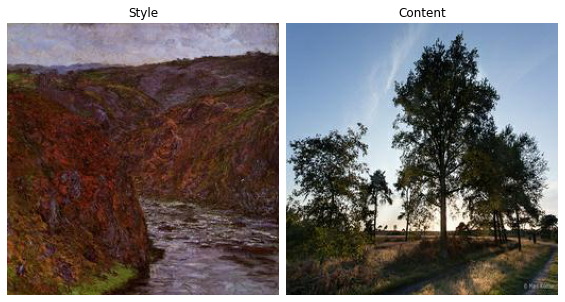

In [62]:
#Create normalized datasets
dataset_monet = ImageDataset(path_monet, img_size=256, normalize=True)
dataset_photo = ImageDataset(path_photo, img_size=256, normalize=True)

#Create test loaders
batch_size_style = 1
batch_size_content = 1
style_loader_Y = DataLoader(dataset_monet, batch_size=batch_size_style, shuffle=False, num_workers=0, pin_memory=True)
content_loader_X = DataLoader(dataset_photo, batch_size=batch_size_content, shuffle=False, num_workers=0, pin_memory=True)

#Dataiter
dataiter_style = iter(style_loader_Y)
dataiter_content = iter(content_loader_X)

#Next image
style_img = dataiter_style.next()
content_img = dataiter_content.next()

#transformation next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
ax1.imshow(im_convert(style_img))
ax1.axis('off')
ax1.set_title('Style')
ax2.imshow(im_convert(content_img))
ax2.axis('off')
ax2.set_title('Content')
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Specific image

In [63]:
style_img = load_image(path_monet+"79292e1434.jpg").to(device) #"853f8d711f.jpg" or "79292e1434.jpg" or "a619072f82.jpg"
content_img = load_image(path_photo+"11bcbf0f67.jpg").to(device)

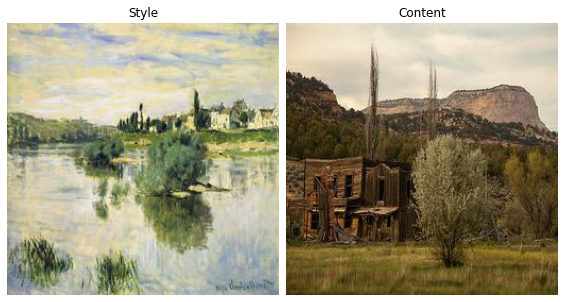

In [64]:
#transformation next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
ax1.imshow(im_convert(style_img))
ax1.axis('off')
ax1.set_title('Style')
ax2.imshow(im_convert(content_img))
ax2.axis('off')
ax2.set_title('Content')
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Creating target image for part 1

In [65]:
# here we create a target_img that we will transform later --> we initialize it as a clone of the content image
target_img = content_img.clone().requires_grad_(True).to(device)

## General style transfer functions

### Pre-trained VGG19

In [66]:
#get the "features" portion of VGG19 (we will not need the "classifier" portion)
loss_model = models.vgg19(pretrained=True).features

#freeze all parameters since we are only optimizing the target image / autoencoder
for param in loss_model.parameters():
    param.requires_grad_(False)

In [67]:
#Move model to correct device (based on availability)
loss_model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Feature extraction

In [68]:
def get_features(image, model, layers=None):
    """Run an image forward through a model and get the features for a set of layers"""
    
    # Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1', #style
                  '5': 'conv2_1', #style
                  '10': 'conv3_1', #style
                  '19': 'conv4_1', #style
                  '21': 'conv4_2', #content
                  '28': 'conv5_1'} #style
    
    features = {}
    x = image
    for name, layer in model._modules.items(): # model._modules is a dictionary holding each module in the model
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

### Calculation of gram matrix - required for style

In [69]:
def gram_matrix(tensor):
    """Calculate the Gram Matrix of a given tensor. More information can be found under https://en.wikipedia.org/wiki/Gramian_matrix"""
    
    #get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    #reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    #calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

## Loss functions

In [70]:
def layer_loss(target_layer, content_layer, layer_weight, method="mse"):
    """Calculates difference between two layers / gram matrices"""
    
    if method == "mse":
        loss_ = torch.mean((target_layer - content_layer)**2)
    
    if method == "mae":
        loss_ = torch.mean(torch.abs(target_layer - content_layer))
        
    return loss_ * layer_weight

In [71]:
def total_loss(target, content_features, style_features, style_grams, loss_model, style_weights, content_weights, alpha_weight, beta_weight, method="mse"):
    """Calculates style and content loss for target image (in comparison with style and content image)"""
    
    #get the features from your target image
    target_features = get_features(target, loss_model)
    
    # =========================================
    # Content loss 
    # =========================================
    
    #initialize the content loss to 0
    content_loss = 0.0
    
    #Loop through each layer
    for layer in content_weights:
        
#         #get the content representation of the target
#         target_feature = target_features[layer]
#         batch_size_, d, h, w = target_feature.shape
        
        #the content loss for one layer, weighted appropriately
        layer_content_loss = layer_loss(target_features[layer], content_features[layer], content_weights[layer], method)
        
        #add to content loss
        content_loss += layer_content_loss #/ (d * h * w)
    
    # =========================================
    # Style loss 
    # =========================================
    
    #initialize the style loss to 0
    style_loss = 0.0
    
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        
        #get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        batch_size_, d, h, w = target_feature.shape
        
        #get the "style" representation
        style_gram = style_grams[layer]
        
        #the style loss for one layer, weighted appropriately
        layer_style_loss = layer_loss(target_gram, style_gram, style_weights[layer], method)
        
        #add to style loss
        style_loss += layer_style_loss / (d * h * w)
    
    # =========================================
    # Perceptual loss 
    # =========================================
    
    #calculate the total loss
    total_loss = alpha_weight * content_loss + beta_weight * style_loss
    
    return total_loss, alpha_weight * content_loss, beta_weight * style_loss

## Optimizer & layer weighting

In [72]:
#hyperparameter
lr=0.002 ##0.0002
beta1=0.900 #exponential decay rate for the first moment estimates
beta2=0.999 #exponential decay rate for the second-moment estimates

#Optimizers for target image
g_optimizer = optim.Adam([target_img], lr, [beta1, beta2])

#scheduling learning rate reduction
scheduler = MultiStepLR(g_optimizer, milestones=[10000], gamma=0.5)

Below, you can weight the style representation at each layer. Weighting the earlier layers (conv1_1 and conv2_1) higher should result in larger style artifacts in the resulting target image. Weighting the later layers should emphasise smaller features.

In [73]:
#Weighting scheme for each layer
style_weights = {'conv1_1': 0.90, #0.90
                 'conv2_1': 0.75, #0.75
                 'conv3_1': 0.50, #0.50
                 'conv4_1': 0.25, #0.25
                 'conv5_1': 0.10} #0.10
content_weights = {'conv4_2': 0.99}

#Content vs. style
alpha_weight = 1.0e1  # content_weight
beta_weight = 1.0e3  # style_weight

The ratio of the alpha and beta weight determines the relative importance of style vs content. A high ratio results in small changes from the content and little style transfer. The lower the ratio the more style is "imported" so to speak. 

In [74]:
print("Ratio of content / style weight is: {:6.6f}".format(alpha_weight / beta_weight))

Ratio of content / style weight is: 0.010000


## Training

In [75]:
def training_loop(style_img, content_img, target_img, n_epochs=1000):
    """Trains residual autoencoder to transform any image to required style
    loss_model, style_weights, content_weights, alpha_weight and beta_weight defined outside of function
    
    """
    
    #Start training time
    start = time.time()
    
    #Admin parameters
    print_every = 100
    show_every = 1000
    checkpoint_every = 5
    
    #Moves images to GPU, if available (!potentially doubled!)
    if torch.cuda.is_available():
        style_img = style_img.to(device)
        content_img = content_img.to(device)
    
    #Losses over time
    losses = []
    
    #get content and style features only once before forming the target image
    content_features = get_features(content_img, loss_model)
    style_features = get_features(style_img, loss_model)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    
    #run training loop
    for epoch in range(1, n_epochs+1):
        
        #Back to the start
        g_optimizer.zero_grad()
        
        #perceptual_loss
        total_perceptual_loss, content_loss, style_loss = total_loss(target_img, content_features, style_features, style_grams, loss_model, style_weights, content_weights, alpha_weight, beta_weight)
        
        #Optimization step
        total_perceptual_loss.backward()
        g_optimizer.step()
        
        # =========================================
        # Admin 
        # =========================================
        
        #Get time since started
        end = time.time()
        elapsed = end - start #in seconds
        elapsed = elapsed/60.0
        
        #print log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((content_loss.item(), style_loss.item(), total_perceptual_loss.item()))
            print('Epoch [{:5d}/{:5d}] | minutes since start: {:6.2f} | content_loss: {:6.4f} | style_loss: {:6.4f} | total_perceptual_loss: {:6.4f}'.format(
                    epoch, n_epochs, elapsed, content_loss.item(), style_loss.item(), total_perceptual_loss.item()))
        
        #show the generated samples
        if epoch % show_every == 0:
            
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 5))
            ax1.imshow(im_convert(style_img))
            ax1.axis('off')
            ax1.set_title('Style')
            ax2.imshow(im_convert(content_img))
            ax2.axis('off')
            ax2.set_title('Content')
            ax3.imshow(im_convert(target_img))
            ax3.axis('off')
            ax3.set_title('Stylized')
            fig.subplots_adjust(wspace=0, hspace=0)
            plt.show()
            
        #Adjust learning rate if requirements meet
        scheduler.step()
        
#         #save the model parameters
#         if epoch % checkpoint_every == 0:
#             save_checkpoint(epoch, target_img)
    
    return losses

## Sample application

Epoch [  100/15000] | minutes since start:   0.05 | content_loss: 13.2587 | style_loss: 445.6227 | total_perceptual_loss: 458.8814
Epoch [  200/15000] | minutes since start:   0.10 | content_loss: 14.0664 | style_loss: 286.3774 | total_perceptual_loss: 300.4438
Epoch [  300/15000] | minutes since start:   0.15 | content_loss: 14.2167 | style_loss: 221.2570 | total_perceptual_loss: 235.4736
Epoch [  400/15000] | minutes since start:   0.21 | content_loss: 14.1841 | style_loss: 188.8888 | total_perceptual_loss: 203.0728
Epoch [  500/15000] | minutes since start:   0.26 | content_loss: 14.1045 | style_loss: 169.5954 | total_perceptual_loss: 183.6999
Epoch [  600/15000] | minutes since start:   0.31 | content_loss: 14.0387 | style_loss: 155.8722 | total_perceptual_loss: 169.9109
Epoch [  700/15000] | minutes since start:   0.36 | content_loss: 13.9852 | style_loss: 144.7744 | total_perceptual_loss: 158.7595
Epoch [  800/15000] | minutes since start:   0.41 | content_loss: 13.9116 | style_l

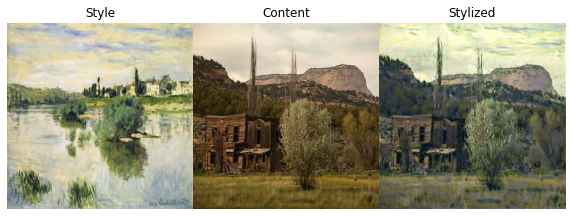

Epoch [ 1100/15000] | minutes since start:   0.57 | content_loss: 13.6933 | style_loss: 111.8570 | total_perceptual_loss: 125.5503
Epoch [ 1200/15000] | minutes since start:   0.63 | content_loss: 13.6374 | style_loss: 105.3405 | total_perceptual_loss: 118.9778
Epoch [ 1300/15000] | minutes since start:   0.68 | content_loss: 13.5918 | style_loss: 99.3078 | total_perceptual_loss: 112.8996
Epoch [ 1400/15000] | minutes since start:   0.73 | content_loss: 13.5410 | style_loss: 93.6834 | total_perceptual_loss: 107.2243
Epoch [ 1500/15000] | minutes since start:   0.78 | content_loss: 13.4837 | style_loss: 88.4399 | total_perceptual_loss: 101.9236
Epoch [ 1600/15000] | minutes since start:   0.83 | content_loss: 13.4330 | style_loss: 83.5154 | total_perceptual_loss: 96.9484
Epoch [ 1700/15000] | minutes since start:   0.89 | content_loss: 13.3842 | style_loss: 78.8789 | total_perceptual_loss: 92.2632
Epoch [ 1800/15000] | minutes since start:   0.94 | content_loss: 13.3357 | style_loss: 74

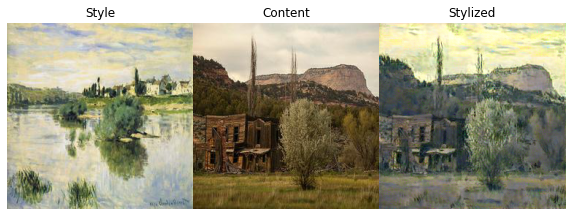

Epoch [ 2100/15000] | minutes since start:   1.10 | content_loss: 13.1842 | style_loss: 62.7534 | total_perceptual_loss: 75.9377
Epoch [ 2200/15000] | minutes since start:   1.15 | content_loss: 13.1280 | style_loss: 59.2088 | total_perceptual_loss: 72.3369
Epoch [ 2300/15000] | minutes since start:   1.20 | content_loss: 13.0807 | style_loss: 55.8277 | total_perceptual_loss: 68.9084
Epoch [ 2400/15000] | minutes since start:   1.25 | content_loss: 13.0309 | style_loss: 52.6176 | total_perceptual_loss: 65.6486
Epoch [ 2500/15000] | minutes since start:   1.31 | content_loss: 12.9861 | style_loss: 49.5578 | total_perceptual_loss: 62.5438
Epoch [ 2600/15000] | minutes since start:   1.36 | content_loss: 12.9380 | style_loss: 46.6583 | total_perceptual_loss: 59.5963
Epoch [ 2700/15000] | minutes since start:   1.41 | content_loss: 12.8983 | style_loss: 43.8983 | total_perceptual_loss: 56.7966
Epoch [ 2800/15000] | minutes since start:   1.46 | content_loss: 12.8521 | style_loss: 41.2935 |

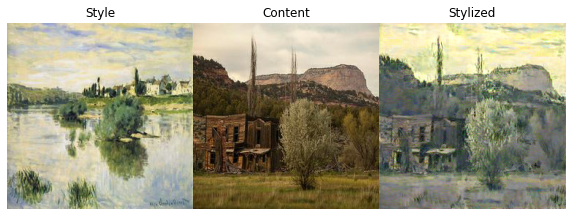

Epoch [ 3100/15000] | minutes since start:   1.62 | content_loss: 12.7259 | style_loss: 34.3476 | total_perceptual_loss: 47.0735
Epoch [ 3200/15000] | minutes since start:   1.68 | content_loss: 12.6843 | style_loss: 32.3161 | total_perceptual_loss: 45.0004
Epoch [ 3300/15000] | minutes since start:   1.73 | content_loss: 12.6529 | style_loss: 30.4127 | total_perceptual_loss: 43.0657
Epoch [ 3400/15000] | minutes since start:   1.78 | content_loss: 12.6178 | style_loss: 28.6528 | total_perceptual_loss: 41.2706
Epoch [ 3500/15000] | minutes since start:   1.83 | content_loss: 12.5813 | style_loss: 27.0245 | total_perceptual_loss: 39.6058
Epoch [ 3600/15000] | minutes since start:   1.88 | content_loss: 12.5328 | style_loss: 25.5487 | total_perceptual_loss: 38.0815
Epoch [ 3700/15000] | minutes since start:   1.94 | content_loss: 12.5191 | style_loss: 24.1613 | total_perceptual_loss: 36.6804
Epoch [ 3800/15000] | minutes since start:   1.99 | content_loss: 12.4782 | style_loss: 22.9093 |

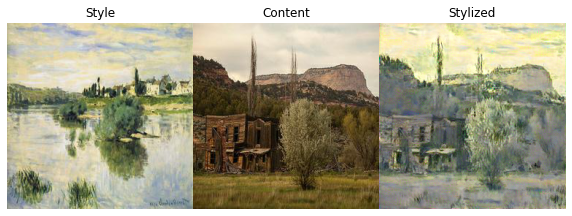

Epoch [ 4100/15000] | minutes since start:   2.15 | content_loss: 12.3964 | style_loss: 19.8131 | total_perceptual_loss: 32.2096
Epoch [ 4200/15000] | minutes since start:   2.20 | content_loss: 12.3400 | style_loss: 18.9700 | total_perceptual_loss: 31.3100
Epoch [ 4300/15000] | minutes since start:   2.25 | content_loss: 12.3084 | style_loss: 18.2155 | total_perceptual_loss: 30.5240
Epoch [ 4400/15000] | minutes since start:   2.30 | content_loss: 12.2921 | style_loss: 17.5073 | total_perceptual_loss: 29.7994
Epoch [ 4500/15000] | minutes since start:   2.36 | content_loss: 12.2733 | style_loss: 16.8846 | total_perceptual_loss: 29.1579
Epoch [ 4600/15000] | minutes since start:   2.41 | content_loss: 12.2518 | style_loss: 16.3397 | total_perceptual_loss: 28.5915
Epoch [ 4700/15000] | minutes since start:   2.46 | content_loss: 12.2231 | style_loss: 15.8358 | total_perceptual_loss: 28.0589
Epoch [ 4800/15000] | minutes since start:   2.51 | content_loss: 12.2054 | style_loss: 15.3827 |

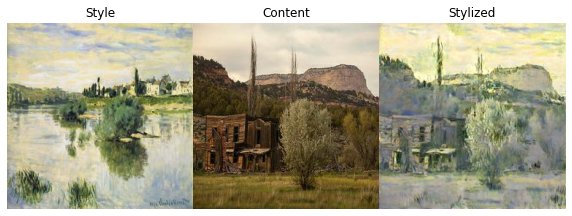

Epoch [ 5100/15000] | minutes since start:   2.67 | content_loss: 12.0937 | style_loss: 14.2848 | total_perceptual_loss: 26.3785
Epoch [ 5200/15000] | minutes since start:   2.72 | content_loss: 12.0574 | style_loss: 14.0108 | total_perceptual_loss: 26.0682
Epoch [ 5300/15000] | minutes since start:   2.78 | content_loss: 12.0727 | style_loss: 13.7281 | total_perceptual_loss: 25.8008
Epoch [ 5400/15000] | minutes since start:   2.83 | content_loss: 12.0068 | style_loss: 13.5375 | total_perceptual_loss: 25.5443
Epoch [ 5500/15000] | minutes since start:   2.88 | content_loss: 12.0265 | style_loss: 13.2831 | total_perceptual_loss: 25.3097
Epoch [ 5600/15000] | minutes since start:   2.93 | content_loss: 11.9620 | style_loss: 13.1011 | total_perceptual_loss: 25.0632
Epoch [ 5700/15000] | minutes since start:   2.98 | content_loss: 11.9617 | style_loss: 12.8915 | total_perceptual_loss: 24.8532
Epoch [ 5800/15000] | minutes since start:   3.04 | content_loss: 11.9441 | style_loss: 12.7299 |

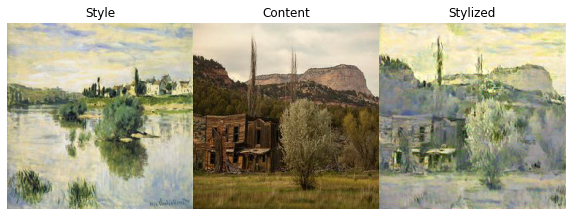

Epoch [ 6100/15000] | minutes since start:   3.20 | content_loss: 11.9126 | style_loss: 12.3443 | total_perceptual_loss: 24.2569
Epoch [ 6200/15000] | minutes since start:   3.25 | content_loss: 11.9231 | style_loss: 12.3231 | total_perceptual_loss: 24.2462
Epoch [ 6300/15000] | minutes since start:   3.30 | content_loss: 11.8643 | style_loss: 12.1014 | total_perceptual_loss: 23.9658
Epoch [ 6400/15000] | minutes since start:   3.35 | content_loss: 11.8571 | style_loss: 12.0331 | total_perceptual_loss: 23.8902
Epoch [ 6500/15000] | minutes since start:   3.40 | content_loss: 11.8089 | style_loss: 11.9449 | total_perceptual_loss: 23.7538
Epoch [ 6600/15000] | minutes since start:   3.46 | content_loss: 11.8076 | style_loss: 11.8349 | total_perceptual_loss: 23.6426
Epoch [ 6700/15000] | minutes since start:   3.51 | content_loss: 11.8014 | style_loss: 11.7508 | total_perceptual_loss: 23.5522
Epoch [ 6800/15000] | minutes since start:   3.56 | content_loss: 11.7601 | style_loss: 11.7409 |

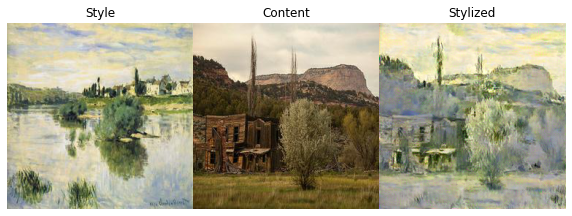

Epoch [ 7100/15000] | minutes since start:   3.72 | content_loss: 11.7221 | style_loss: 11.5416 | total_perceptual_loss: 23.2638
Epoch [ 7200/15000] | minutes since start:   3.77 | content_loss: 11.7469 | style_loss: 11.4275 | total_perceptual_loss: 23.1745
Epoch [ 7300/15000] | minutes since start:   3.82 | content_loss: 11.7390 | style_loss: 11.3999 | total_perceptual_loss: 23.1389
Epoch [ 7400/15000] | minutes since start:   3.88 | content_loss: 11.7082 | style_loss: 11.3351 | total_perceptual_loss: 23.0432
Epoch [ 7500/15000] | minutes since start:   3.93 | content_loss: 11.6861 | style_loss: 11.3015 | total_perceptual_loss: 22.9876
Epoch [ 7600/15000] | minutes since start:   3.98 | content_loss: 11.6815 | style_loss: 11.2476 | total_perceptual_loss: 22.9291
Epoch [ 7700/15000] | minutes since start:   4.03 | content_loss: 11.6794 | style_loss: 11.1828 | total_perceptual_loss: 22.8622
Epoch [ 7800/15000] | minutes since start:   4.08 | content_loss: 11.6956 | style_loss: 11.1622 |

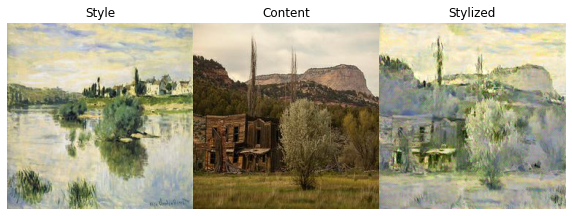

Epoch [ 8100/15000] | minutes since start:   4.24 | content_loss: 11.6672 | style_loss: 11.0544 | total_perceptual_loss: 22.7216
Epoch [ 8200/15000] | minutes since start:   4.30 | content_loss: 11.6357 | style_loss: 11.0151 | total_perceptual_loss: 22.6509
Epoch [ 8300/15000] | minutes since start:   4.35 | content_loss: 11.6340 | style_loss: 10.9633 | total_perceptual_loss: 22.5973
Epoch [ 8400/15000] | minutes since start:   4.40 | content_loss: 11.6019 | style_loss: 11.0181 | total_perceptual_loss: 22.6200
Epoch [ 8500/15000] | minutes since start:   4.45 | content_loss: 11.6275 | style_loss: 10.9242 | total_perceptual_loss: 22.5516
Epoch [ 8600/15000] | minutes since start:   4.50 | content_loss: 11.6000 | style_loss: 10.8885 | total_perceptual_loss: 22.4885
Epoch [ 8700/15000] | minutes since start:   4.56 | content_loss: 11.5843 | style_loss: 10.9225 | total_perceptual_loss: 22.5068
Epoch [ 8800/15000] | minutes since start:   4.61 | content_loss: 11.5762 | style_loss: 10.8806 |

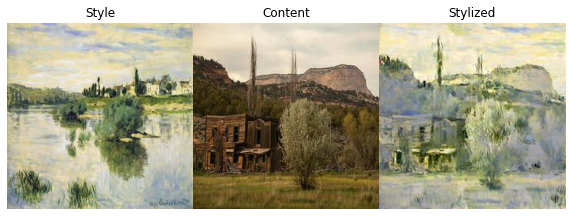

Epoch [ 9100/15000] | minutes since start:   4.77 | content_loss: 11.6000 | style_loss: 10.7794 | total_perceptual_loss: 22.3794
Epoch [ 9200/15000] | minutes since start:   4.82 | content_loss: 11.5683 | style_loss: 10.7301 | total_perceptual_loss: 22.2984
Epoch [ 9300/15000] | minutes since start:   4.87 | content_loss: 11.5681 | style_loss: 10.7187 | total_perceptual_loss: 22.2868
Epoch [ 9400/15000] | minutes since start:   4.92 | content_loss: 11.5423 | style_loss: 10.7438 | total_perceptual_loss: 22.2861
Epoch [ 9500/15000] | minutes since start:   4.98 | content_loss: 11.5444 | style_loss: 10.7046 | total_perceptual_loss: 22.2490
Epoch [ 9600/15000] | minutes since start:   5.03 | content_loss: 11.5673 | style_loss: 10.6415 | total_perceptual_loss: 22.2088
Epoch [ 9700/15000] | minutes since start:   5.08 | content_loss: 11.5785 | style_loss: 10.6501 | total_perceptual_loss: 22.2286
Epoch [ 9800/15000] | minutes since start:   5.13 | content_loss: 11.5585 | style_loss: 10.6057 |

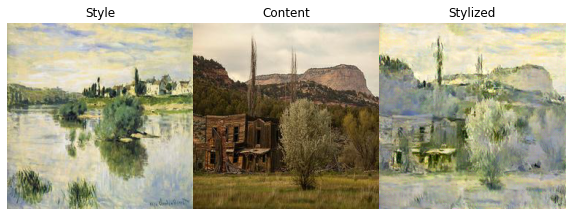

Epoch [10100/15000] | minutes since start:   5.29 | content_loss: 11.5367 | style_loss: 10.5454 | total_perceptual_loss: 22.0822
Epoch [10200/15000] | minutes since start:   5.35 | content_loss: 11.5350 | style_loss: 10.5374 | total_perceptual_loss: 22.0724
Epoch [10300/15000] | minutes since start:   5.40 | content_loss: 11.5332 | style_loss: 10.5299 | total_perceptual_loss: 22.0631
Epoch [10400/15000] | minutes since start:   5.45 | content_loss: 11.5315 | style_loss: 10.5221 | total_perceptual_loss: 22.0536
Epoch [10500/15000] | minutes since start:   5.50 | content_loss: 11.5294 | style_loss: 10.5143 | total_perceptual_loss: 22.0436
Epoch [10600/15000] | minutes since start:   5.55 | content_loss: 11.5283 | style_loss: 10.5053 | total_perceptual_loss: 22.0336
Epoch [10700/15000] | minutes since start:   5.61 | content_loss: 11.5264 | style_loss: 10.4973 | total_perceptual_loss: 22.0237
Epoch [10800/15000] | minutes since start:   5.66 | content_loss: 11.5252 | style_loss: 10.4887 |

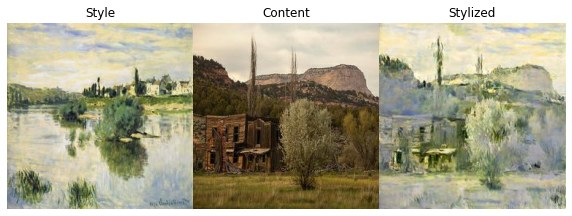

Epoch [11100/15000] | minutes since start:   5.82 | content_loss: 11.5180 | style_loss: 10.4668 | total_perceptual_loss: 21.9848
Epoch [11200/15000] | minutes since start:   5.87 | content_loss: 11.5247 | style_loss: 10.4529 | total_perceptual_loss: 21.9776
Epoch [11300/15000] | minutes since start:   5.92 | content_loss: 11.5025 | style_loss: 10.4736 | total_perceptual_loss: 21.9761
Epoch [11400/15000] | minutes since start:   5.98 | content_loss: 11.5116 | style_loss: 10.4418 | total_perceptual_loss: 21.9533
Epoch [11500/15000] | minutes since start:   6.03 | content_loss: 11.5232 | style_loss: 10.4290 | total_perceptual_loss: 21.9522
Epoch [11600/15000] | minutes since start:   6.08 | content_loss: 11.5026 | style_loss: 10.4282 | total_perceptual_loss: 21.9308
Epoch [11700/15000] | minutes since start:   6.13 | content_loss: 11.5003 | style_loss: 10.4195 | total_perceptual_loss: 21.9198
Epoch [11800/15000] | minutes since start:   6.18 | content_loss: 11.4980 | style_loss: 10.4124 |

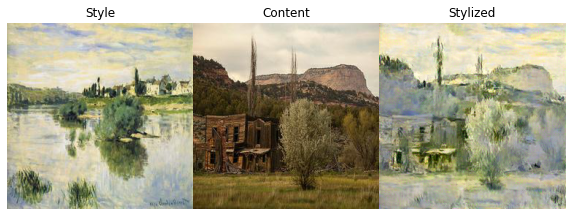

Epoch [12100/15000] | minutes since start:   6.34 | content_loss: 11.4958 | style_loss: 10.3770 | total_perceptual_loss: 21.8728
Epoch [12200/15000] | minutes since start:   6.40 | content_loss: 11.4770 | style_loss: 10.3865 | total_perceptual_loss: 21.8635
Epoch [12300/15000] | minutes since start:   6.45 | content_loss: 11.4932 | style_loss: 10.3593 | total_perceptual_loss: 21.8525
Epoch [12400/15000] | minutes since start:   6.50 | content_loss: 11.4791 | style_loss: 10.3566 | total_perceptual_loss: 21.8357
Epoch [12500/15000] | minutes since start:   6.55 | content_loss: 11.4831 | style_loss: 10.3394 | total_perceptual_loss: 21.8225
Epoch [12600/15000] | minutes since start:   6.60 | content_loss: 11.4918 | style_loss: 10.3319 | total_perceptual_loss: 21.8237
Epoch [12700/15000] | minutes since start:   6.66 | content_loss: 11.4862 | style_loss: 10.3255 | total_perceptual_loss: 21.8117
Epoch [12800/15000] | minutes since start:   6.71 | content_loss: 11.4657 | style_loss: 10.3362 |

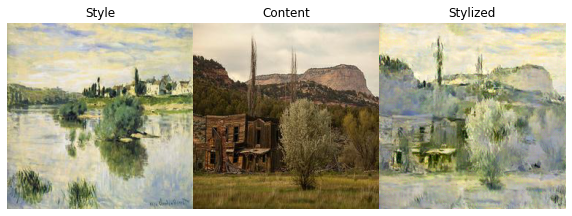

Epoch [13100/15000] | minutes since start:   6.87 | content_loss: 11.4760 | style_loss: 10.2917 | total_perceptual_loss: 21.7677
Epoch [13200/15000] | minutes since start:   6.92 | content_loss: 11.4721 | style_loss: 10.2884 | total_perceptual_loss: 21.7605
Epoch [13300/15000] | minutes since start:   6.97 | content_loss: 11.4646 | style_loss: 10.2821 | total_perceptual_loss: 21.7467
Epoch [13400/15000] | minutes since start:   7.03 | content_loss: 11.4538 | style_loss: 10.2917 | total_perceptual_loss: 21.7456
Epoch [13500/15000] | minutes since start:   7.08 | content_loss: 11.4505 | style_loss: 10.2957 | total_perceptual_loss: 21.7462
Epoch [13600/15000] | minutes since start:   7.13 | content_loss: 11.4697 | style_loss: 10.2590 | total_perceptual_loss: 21.7287
Epoch [13700/15000] | minutes since start:   7.18 | content_loss: 11.4635 | style_loss: 10.2583 | total_perceptual_loss: 21.7218
Epoch [13800/15000] | minutes since start:   7.23 | content_loss: 11.4474 | style_loss: 10.2666 |

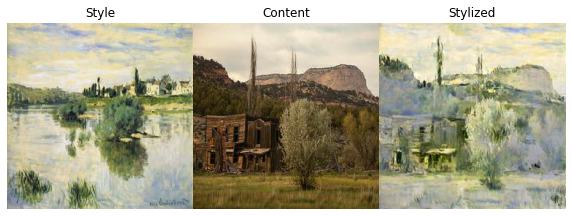

Epoch [14100/15000] | minutes since start:   7.39 | content_loss: 11.4398 | style_loss: 10.2537 | total_perceptual_loss: 21.6934
Epoch [14200/15000] | minutes since start:   7.45 | content_loss: 11.4502 | style_loss: 10.2266 | total_perceptual_loss: 21.6768
Epoch [14300/15000] | minutes since start:   7.50 | content_loss: 11.4595 | style_loss: 10.2224 | total_perceptual_loss: 21.6820
Epoch [14400/15000] | minutes since start:   7.55 | content_loss: 11.4597 | style_loss: 10.2168 | total_perceptual_loss: 21.6764
Epoch [14500/15000] | minutes since start:   7.60 | content_loss: 11.4347 | style_loss: 10.2275 | total_perceptual_loss: 21.6621
Epoch [14600/15000] | minutes since start:   7.65 | content_loss: 11.4433 | style_loss: 10.2049 | total_perceptual_loss: 21.6482
Epoch [14700/15000] | minutes since start:   7.71 | content_loss: 11.4283 | style_loss: 10.2247 | total_perceptual_loss: 21.6530
Epoch [14800/15000] | minutes since start:   7.76 | content_loss: 11.4511 | style_loss: 10.1925 |

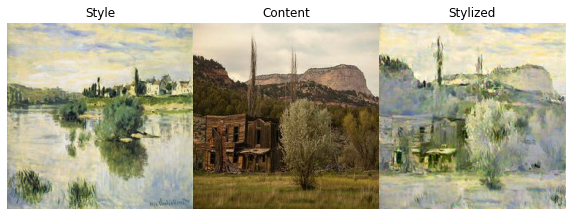

In [76]:
#go train!
losses = training_loop(style_img, content_img, target_img, n_epochs=15000)

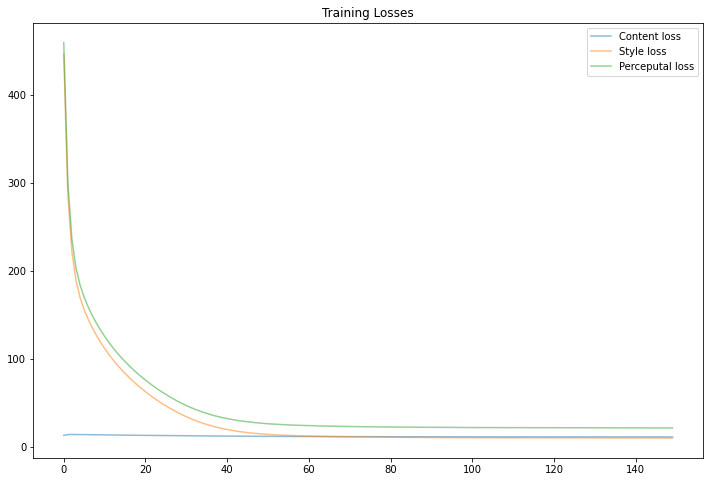

In [77]:
#Plot loss functions over training
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Content loss', alpha=0.5)
plt.plot(losses.T[1], label='Style loss', alpha=0.5)
plt.plot(losses.T[2], label='Perceputal loss', alpha=0.5)
plt.title("Training Losses")
plt.legend()
plt.show()

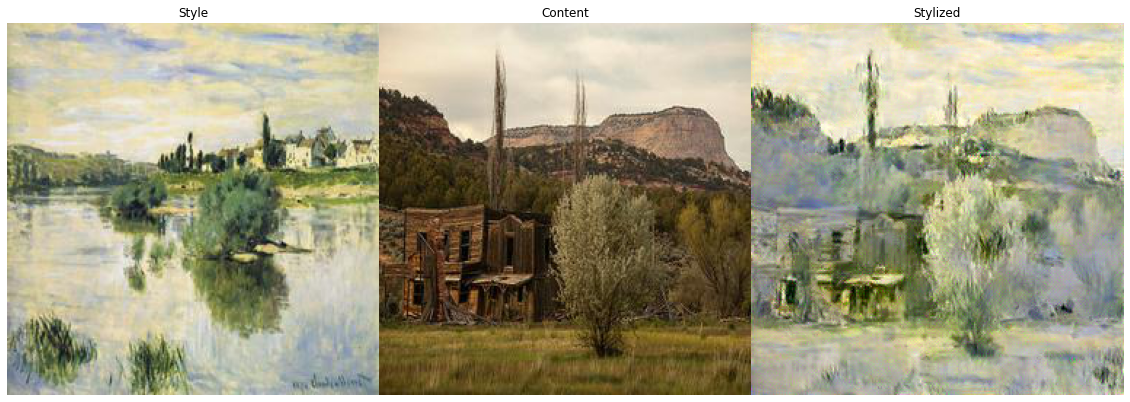

In [78]:
#Plot final result
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20, 10))
ax1.imshow(im_convert(style_img))
ax1.axis('off')
ax1.set_title('Style')
ax2.imshow(im_convert(content_img))
ax2.axis('off')
ax2.set_title('Content')
ax3.imshow(im_convert(target_img))
ax3.axis('off')
ax3.set_title('Stylized')
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()